In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


# 개요
[참고한 사이트](https://www.kaggle.com/code/heyrobin/spaceship-titanic-a-cosmic-mystery) SpaceTitanic Kaggle Competition 링크 글을 참고하여 코드를 따라쓰며 필자가 해석한 부분을 설명하면서 머신러닝에 대해 이해하기 위한 목적으로 작성하게 되었습니다.

<strong>Data</strong> - 승객의 약 3분의 2(~8700)에 대한 개인 기록은 훈련 데이터로 사용됩니다.
<ul><li><code>PassengerId</code> - 각 승객의 고유 ID. 각 ID는 <code>gggg_pp</code> 형식을 취하며, 여기서 <code>gggg</code>는 승객이 함께 여행하는 그룹을 나타내며, <code>pp</code>는 그룹 내 번호를 나타냅니다. 그룹의 사람들은 대게 가족 구성원이지만 항상 그렇만은 않습니다.</li>
<li><code>HomePlanet</code> - 승객이 출발한 행성으로, 일반적으로 그들의 영구 거주지 행성입니다.</li>
<li><code>CryoSleep</code> - 객이 항해가 진행되는 동안 가사상태로 전환되도록 선택했는지 여부를 나타냅니다. 저온 수면 중인 승객들은 객실에 있게 된다.</li>
<li><code>Cabin</code> - 승객이 머물고 있는 객실 번호입니다. 갑판/번호/측면<code>deck/num/side</code>형식을 취합니다. 여기서 측면<code>side</code>은 좌측이 <code>P</code>, <em>Port</em> 또는 우측이 <code>S</code>, <em>Starboard</em>가 될 수 있습니다.</li>
<li><code>Destination</code> - 승객이 정박할 목적지 행성입니다.</li>
<li><code>Age</code> - 승객의 나이를 나타냅니다.</li>
<li><code>VIP</code> - 승객이 항해 중 특별 VIP 서비스를 위해 비용을 지불했는지 여부를 나타낸 것 입니다.</li>
<li><code>RoomService</code>, <code>FoodCourt</code>, <code>ShoppingMall</code>, <code>Spa</code>, <code>VRDeck</code> - 승객들이 <em>Spaceship Titanic</em>의 많은 고급 편의시설에서 청구한 금액입니다. </li>
<li><code>Name</code> - 승객들의 이름을 나타냅니다.</li>
<li><code>Transported</code> - 승객이 다른 차원으로 이송되었는지 여부. 예측하려는 대상 열입니다.</li></ul></li>

# Step 1. 라이브러리 및 데이터 불러오기

In [2]:
'''Analysis(분석)'''

import numpy as np
import pandas as pd
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt

'''Pre-Processing(데이터 전처리)'''
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

'''Model-Metrics(모형 개발 및 평가)'''
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

'''Dataset'''
train = pd.read_csv('../input/spaceship-titanic/train.csv')
test = pd.read_csv('../input/spaceship-titanic/test.csv')

- 라이브러리 버전 확인

In [3]:
print(np.__version__)
print(pd.__version__)
print(sns.__version__)

1.20.3
1.3.5
0.11.2


- 데이터 확인
    + 훈련데이터는 8,693개, 테스트 데이터는 4,277개로 구성이 되어 있음
    + 독립변수 컬럼 갯수는 13개이며, 종속 변수는 1개로 구성되어 있음

In [4]:
train.shape, test.shape

((8693, 14), (4277, 13))

In [5]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


- 컬럼별 레이블의 개수 확인
    + data_Frame.nunique() = 데이터셋에 존재하는 컬럼별 레이블의 개수를 확인하기 위해 사용

In [7]:
train.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

# Step 2. 탐색적 자료 분석 (EDA)
- 데이터 시각화
- 산점도, 막대 그래프 등
- 그래프 해석 및 설명
- 약간의 데이터 전처리

- HomePlanet

In [8]:
cnt_srs = train['HomePlanet'].value_counts()

trace = go.Scatter(
    x = cnt_srs.index,
    y = cnt_srs.values,
    mode = 'markers',
    marker = dict(
        sizemode = 'diameter',
        sizeref = 20,
        size = cnt_srs.values,
        color = ['#1D7595','#B9B596','#864D29']

    ),
)

layout = go.Layout(
    title = '<b>Home Planets</b>', 
    title_x = 0.5,
    titlefont = dict(size =20, color='black', family='Space Mono'),
    plot_bgcolor = 'rgba(0,0,0,0)'
)

data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.update_xaxes(showline = True, linewidth = 2,
                 #linecolor = colors[3]
                )
fig.update_yaxes(showline = True, linewidth = 2,
                 #linecolor = colors[3]
                )
py.iplot(fig, filename = "Size of the Company/Clan")

    + Earth: 4602
    + Europa: 2131
    + Mars: 1759

- Destination

In [9]:
cnt_srs = train['Destination'].value_counts()

trace = go.Scatter(
    x = cnt_srs.index,
    y = cnt_srs.values,
    mode = 'markers',
    marker = dict(
        sizemode = 'diameter',
        sizeref = 20,
        size = cnt_srs.values,
        color = ['#048B95','#A1231F','#602F58']
    ),
)



layout = go.Layout(
    title = '<b>Destination</b>', 
    title_x = 0.5,
    titlefont = dict(size = 20, color = 'black', family = 'Space Mono'),
    
    plot_bgcolor = 'rgba(0,0,0,0)'
)

fig = go.Figure(data = [trace], layout = layout)

sources = "https://assets.stickpng.com/images/580b585b2edbce24c47b2d2a.png"
# add images

fig.add_layout_image(
        source=sources,
        xref = "x domain",
        yref = "y domain",
        x = 0.2,
        y = 0.8,
        xanchor = "right",
        yanchor = "top",
        sizex = 1,
        sizey = 0.7,
        opacity = False
    )

fig.update_xaxes(showline=True, linewidth=2)
fig.update_yaxes(showline=True, linewidth=2)

    + TRAPPIST-1e: 5915
    + 55 Cancri e: 1800
    + PSO J318.5-22: 796

- Age Distribution

In [10]:
trace = go.Histogram(x = train['Age'],
                            histnorm = 'percent',
                            xbins = dict(
                                start = 0,
                                end = 100,
                                size = 1),
                            marker_color = '#048B95',
                            )


layout = go.Layout(
    title = '<b>Age Distribution</b>',
    title_x = 0.5,
    titlefont = dict(size = 20, color = 'black', family = 'Space Mono'),
    plot_bgcolor = 'rgba(0, 0, 0, 0)',
    xaxis_title = 'Age',
    yaxis_title = 'Percent'
)


fig = go.Figure(data = [trace], layout = layout)

fig.update_xaxes(showline = True, linewidth = 2)
fig.update_yaxes(showline = True, linewidth = 2)

py.iplot(fig, filename = "planets")

# Step 3. 데이터 전처리
- Feature Engineering
- ML 모형을 돌리기 위해 표준화 등 / 원핫 - 인코딩
- 파생변수 (도출 변수)
    + 왜 이 변수를 만들었는지에 대한 설명 필요

- 필요없는 특성 정리
    + drop(inplce = True) : 기존 프레임에 변경된 설정으로 덮어쓰겠다는 의미, 그렇기 때문에 다시 데이터 프레임을 가져왔을때 출력되지 않음. [참고링크](http://)

In [11]:
# taking target variable and droping it
y = train['Transported']
train = train.drop('Transported', axis = 1)
train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre


- 불필요한 변수 제거
    + Name, PassengerId, Cabin
    + Cabin은 모형 개선 시, 문자열 처리를 통해 추가 변수를 도출 할수는 있지만, 일단 제거한다.

In [12]:
#cols_to_drop = ['Name', 'PassengerId']
cols_to_drop = ['Name', 'PassengerId', 'Cabin']
def drop(train,test,cols):
    train.drop(cols, axis = 1, inplace = True)
    test.drop(cols, axis = 1, inplace = True)
    print('sucessfully droped features')
    
drop(train, test, cols_to_drop)

sucessfully droped features


In [13]:
train

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0
...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0
8689,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0
8690,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0
8691,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0


In [14]:
#train[['Deck', 'Num', 'Side']] = train['Cabin'].str.split('/', expand = True)
#test[['Deck', 'Num', 'Side']] = train['Cabin'].str.split('/', expand=True)

- Categorical Feature Encoding
    + 머신러닝 알고리즘은 수식으로 구성이 되어 있기 때문에 문자열의 경우 인코딩으로 변환을 주어야 한다. 

In [15]:
# getting categorical and numerical feature
cat_col = [col for col in train.columns if train[col].dtype not in ["float64"]]
num_col = [col for col in train.columns if train[col].dtype in ["float64"]]

- **Handling Missing Values /Imputation**

In [16]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(random_state = 0, max_iter = 10, initial_strategy = 'mean')

train[num_col] = imputer.fit_transform(train[num_col])
test[num_col] = imputer.fit_transform(test[num_col])

In [17]:
train[cat_col] = train[cat_col].fillna('Nan')
test[cat_col] = test[cat_col].fillna('Nan')

In [18]:
train[cat_col]

,HomePlanet,CryoSleep,Destination,VIP
0,Europa,False,TRAPPIST-1e,False
1,Earth,False,TRAPPIST-1e,False
2,Europa,False,TRAPPIST-1e,True
3,Europa,False,TRAPPIST-1e,False
4,Earth,False,TRAPPIST-1e,False
...,...,...,...,...
8688,Europa,False,55 Cancri e,True
8689,Earth,True,PSO J318.5-22,False
8690,Earth,False,TRAPPIST-1e,False
8691,Europa,False,55 Cancri e,False


In [19]:
test[num_col]

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,27.000000,0.0,0.0,0.0,0.0,0.0
1,19.000000,0.0,9.0,0.0,2823.0,0.0
2,31.000000,0.0,0.0,0.0,0.0,0.0
3,38.000000,0.0,6652.0,0.0,181.0,585.0
4,20.000000,10.0,0.0,635.0,0.0,0.0
...,...,...,...,...,...,...
4272,34.000000,0.0,0.0,0.0,0.0,0.0
4273,42.000000,0.0,847.0,17.0,10.0,144.0
4274,27.368784,0.0,0.0,0.0,0.0,0.0
4275,29.561269,0.0,2680.0,0.0,0.0,523.0


# Step 4. 머신러닝 모형 개발

In [20]:
def label_encoder(df, df2, columns):
    for col in columns:
        df[col] = df[col].astype(str)
        df2[col] = df2[col].astype(str)
        df[col] = LabelEncoder().fit_transform(df[col])
        df2[col] = LabelEncoder().fit_transform(df2[col])
    return df

label_encoder(train,test,cat_col)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,1,0,3,39.0,0,0.0,0.0,0.0,0.0,0.0
1,0,0,3,24.0,0,109.0,9.0,25.0,549.0,44.0
2,1,0,3,58.0,2,43.0,3576.0,0.0,6715.0,49.0
3,1,0,3,33.0,0,0.0,1283.0,371.0,3329.0,193.0
4,0,0,3,16.0,0,303.0,70.0,151.0,565.0,2.0
...,...,...,...,...,...,...,...,...,...,...
8688,1,0,0,41.0,2,0.0,6819.0,0.0,1643.0,74.0
8689,0,2,2,18.0,0,0.0,0.0,0.0,0.0,0.0
8690,0,0,3,26.0,0,0.0,0.0,1872.0,1.0,0.0
8691,1,0,0,32.0,0,0.0,1049.0,0.0,353.0,3235.0


In [21]:
X = train

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [23]:
models = {"LogisticClassifier":LogisticRegression(solver='liblinear'),
          "KNearest": KNeighborsClassifier(),
          "Support Vector Classifier": SVC(),
          "DecisionTreeClassifier": DecisionTreeClassifier(),
          "XGBClassifier":XGBClassifier(),
          "LightLGBM Classifier":LGBMClassifier(),
          #"CatBoostClassifier":CatBoostClassifier()
          }

In [24]:
for name, vals in models.items():
    model = vals.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test,y_pred)
    print(f'{name} accuracy is {score}')

LogisticClassifier accuracy is 0.7692575810386895
KNearest accuracy is 0.7689090275357268
Support Vector Classifier accuracy is 0.77448588358313
DecisionTreeClassifier accuracy is 0.7246427326594632
[08:32:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier accuracy is 0.7814569536423841
LightLGBM Classifier accuracy is 0.7905193447194144


# Step 5. 하이퍼파라미터튜닝 및 모형 평가

In [25]:
"""import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
             
      n_estimators = trial.suggest_int("n_estimators", 50, 200)
      learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3)
      num_leaves = trial.suggest_int("num_leaves", 20, 3000, step=20)
      max_depth = trial.suggest_int("max_depth", 3, 12)
      min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 200, 10000, step=100)
      lambda_l1 = trial.suggest_int("lambda_l1", 0, 100, step=5)
      lambda_l2 = trial.suggest_int("lambda_l2", 0, 100, step=5)
      min_gain_to_split = trial.suggest_float("min_gain_to_split", 0, 15)
      bagging_fraction = trial.suggest_float("bagging_fraction", 0.2, 0.95, step=0.1)
      bagging_freq = trial.suggest_categorical("bagging_freq", [1])
      feature_fraction = trial.suggest_float("feature_fraction", 0.2, 0.95, step=0.1)
        
      lgbc = LGBMClassifier(n_estimators=n_estimators,
                            #max_depth=max_depth,
                            learning_rate=learning_rate,
                            #num_leaves =num_leaves,
                            max_depth=max_depth,
                            min_data_in_leaf=min_data_in_leaf,
                            #lambda_l1=lambda_l1,
                            #lambda_l2=lambda_l2,
                            #min_gain_to_split=min_gain_to_split,
                            #bagging_fraction=bagging_fraction,
                            #bagging_freq=bagging_freq,
                            #feature_fraction=feature_fraction
                           )
    
      return cross_val_score(lgbc,
                             X,
                             y,
                             n_jobs=-1,
                             cv=3).mean()
                             
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

trial = study.best_trial
print('Accuracy: {}'.format(trial.value))

print("Best hyperparameters: {}".format(trial.params))

best_params = trial.params

                             
"""

'import optuna\nfrom sklearn.model_selection import cross_val_score\n\ndef objective(trial):\n             \n      n_estimators = trial.suggest_int("n_estimators", 50, 200)\n      learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3)\n      num_leaves = trial.suggest_int("num_leaves", 20, 3000, step=20)\n      max_depth = trial.suggest_int("max_depth", 3, 12)\n      min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 200, 10000, step=100)\n      lambda_l1 = trial.suggest_int("lambda_l1", 0, 100, step=5)\n      lambda_l2 = trial.suggest_int("lambda_l2", 0, 100, step=5)\n      min_gain_to_split = trial.suggest_float("min_gain_to_split", 0, 15)\n      bagging_fraction = trial.suggest_float("bagging_fraction", 0.2, 0.95, step=0.1)\n      bagging_freq = trial.suggest_categorical("bagging_freq", [1])\n      feature_fraction = trial.suggest_float("feature_fraction", 0.2, 0.95, step=0.1)\n        \n      lgbc = LGBMClassifier(n_estimators=n_estimators,\n                         

In [26]:
#optuna.visualization.plot_optimization_history(study)
#optuna.visualization.plot_slice(study)

In [27]:
lgbc = LGBMClassifier(
    #**best_params
).fit(X_train, y_train)
y_pred = lgbc.predict(X_test)
score=accuracy_score(y_test,y_pred)
print(score)

0.7905193447194144


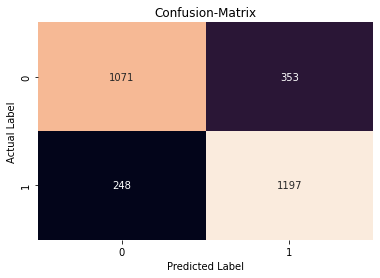

In [28]:
sns.heatmap(confusion_matrix(y_test, y_pred),
                annot = True,
                cbar= False,
                fmt='g',
               #cmap= theme
               )
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion-Matrix');

# Step 6. 제출

In [29]:
sub = pd.read_csv('../input/spaceship-titanic/sample_submission.csv')
sub['Transported'] = lgbc.predict(test)
sub.to_csv('submission.csv',index=False)
sub.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
